# Exercise 6: Arbitrary distributions, moving averages, and Monte-Carlo
## Solutions


In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

## 1. Sampling from an arbitrary distribution
As seen in exercise 4, you can use uniformly distributed random variables, which are in principle themselves simple to generate, to draw samples from the normal distribution via the Box-Muller transform. A more general approach is to sample according to the inverse of the cumulative distribution function (CDF).

A simple example is to generate numbers from the exponential distribution.

$$ f(t;\lambda) = \lambda e^{-\lambda t} $$

* Write the CDF $F(T,\lambda)$ and find its inverse ($T=...$)
* Write a function to compute this, and compare your result to that from scipy (hint: sometimes called percent-point function or quantile function)


C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log


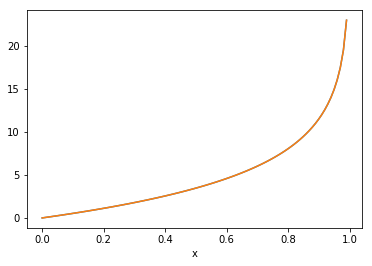

In [2]:
# Quantile function
def exp_quantile(p, l):
    p[p<0] = 0
    p[p>=1] = 1
    return -np.log(1-p)/l  # scipy equivalent: stats.expon.ppf(p,0,1/l)

p = np.linspace(0, 1, 100)
l = 0.2
plt.figure()
plt.plot(p, exp_quantile(p, l))
plt.plot(p, stats.expon.ppf(p,0,1/l))
plt.xlabel('x')
plt.show()

* Now draw N samples from the uniform distribution $[0,1]$. For each sample, calculate $F^{-1}(u,\lambda)$
* Plot a histogram and compare the distribution of points to the exponential pdf


Actual: 0.2
Estimated:  0.19919715788379894


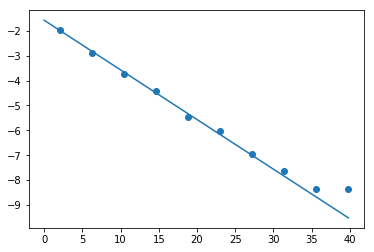

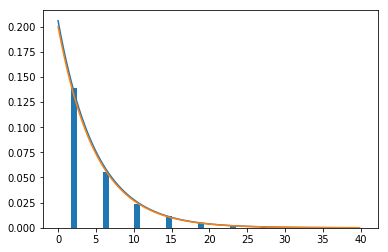

In [3]:
def logfit(x, y):
    good = y > 0
    ly = np.log(y[good])
    return np.polyfit(x[good], ly, 1, w=np.sqrt(y[good]))

N = 1000
l = 0.2
x = np.random.rand(N)
y = exp_quantile(x, l)

hist, bins = np.histogram(y, bins=10, normed=True)
bc = 0.5*(bins[:-1] + bins[1:])

popt = logfit(bc, hist)

print('Actual:', l)
print('Estimated: ', -popt[0])

q = np.linspace(0, bc[-1], 200)


# Check the fit
valid = hist>0
plt.figure()
plt.scatter(bc[valid], np.log(hist[valid]), marker='o')
plt.plot(q, np.polyval(popt, q))

# Plot histogram, fit, and calculated pdf
plt.figure()
plt.bar(bc, hist)
plt.plot(q, np.exp(np.polyval(popt, q)))
plt.plot(q, stats.expon.pdf(q, scale=1/l))
plt.show()



# 2. Smoothing data
## 2.1 Moving average
The moving average, or rolling mean, is a simple technique which can be used to remove short term or periodic (e.g. seasonal) variations in time series data, for example. It can be viewed as a "smoothing", and can ease trend spotting, for instance. One has to be careful when interpreting and using the result; for instance, it is generally improper to fit on such data.

The simplest moving average can be computed using a "sliding window" of length $N$, with all weights equal. For example, for a 3 point moving average, the window would be $\frac{1}{3}[1,1,1]$.

* Write a function to compute the $N$ point moving average of a data series

In [4]:
def moving_average(y, length):
    return np.convolve(np.ones(length)/length, y, 'same')

The following line of code loads a dataset (into a ```pandas DataFrame```) containing monthly measurements of variation in the global surface temperature, stretching back as far as 1750. (More data like this can be found on http://berkeleyearth.org).

In [5]:
df = pd.read_csv('Material/Complete_TAVG_complete.txt', skipinitialspace=True, delimiter=' ', comment='%')
df['Date'] = df.apply(lambda row: datetime.datetime(
                              int(row['Year']), int(row['Month']), 15), axis=1)
df

Year  Month  MDiff   MUnc  YDiff   YUnc  5YDiff  5YUnc  10YDiff  10YUnc  \
0     1750      1 -0.121  4.187 -0.687  2.557  -0.364  0.897   -0.160     NaN   
1     1750      2 -1.278  3.177 -0.691  1.733  -0.381  0.904   -0.169     NaN   
2     1750      3  0.112  3.550 -0.721  1.568  -0.401  0.918   -0.164     NaN   
3     1750      4  0.026  2.862 -0.734  1.609  -0.452  0.951   -0.168     NaN   
4     1750      5 -1.420  2.611 -1.043  1.553  -0.439  1.022   -0.167     NaN   
5     1750      6 -1.029  3.379 -1.004  1.271  -0.414  1.060   -0.176     NaN   
6     1750      7 -0.262  2.722 -1.049  1.026  -0.411  1.023   -0.183     NaN   
7     1750      8  0.290  3.219 -1.137  0.792  -0.466  0.933   -0.210     NaN   
8     1750      9 -0.851  2.121 -1.107  0.775  -0.375  0.945   -0.230     NaN   
9     1750     10 -1.448  3.078 -1.167  0.826  -0.394  1.023   -0.211     NaN   
10    1750     11 -3.518  1.996 -1.160  1.283  -0.423  1.094   -0.226   0.879   
11    1750     12 -2.538  4.091 -1.210  1.458  -0.451  1.143   -0.250   0.894   
12    1751      1 -0.659  3.318 -1.094  1.533  -0.464  1.148   -0.258   0.844   
13    1751      2 -2.341  4.503 -1.047  1.776  -0.482  1.131   -0.231   0.914   
14    1751      3  0.477  2.778 -1.068  1.673  -0.488  1.200   -0.201   0.952   
15    1751      4 -0.690  2.489 -0.933  1.504  -0.492  1.245   -0.184   1.004   
16    1751      5 -1.338  3.435 -0.771  1.606  -0.486  1.336   -0.184   1.019   
17    1751      6 -1.637  3.336 -0.721  1.085  -0.539  1.393   -0.188   1.075   
18    1751      7  1.130  3.753 -0.876  1.400  -0.527  1.212   -0.208   1.084   
19    1751      8  0.858  2.757 -0.409  1.841  -0.538  1.097   -0.221   1.106   
20    1751      9 -1.098  2.928 -0.382  1.840  -0.531  1.123   -0.225   1.119   
21    1751     10  0.169  4.986 -0.429  1.791  -0.446  1.151   -0.219   1.148   
22    1751     11 -1.577  2.326 -0.302  1.688  -0.437  1.160   -0.222   1.178   
23    1751     12 -1.935  3.412 -0.129  1.784  -0.426  1.293   -0.258   1.173   
24    1752      1 -2.523  4.962 -0.154  1.757  -0.431  1.296   -0.262   1.160   
25    1752      2  3.263  4.891 -0.311  1.743  -0.461  1.061   -0.216   1.213   
26    1752      3  0.804  3.040 -0.166  1.570  -0.480  1.053   -0.192   1.258   
27    1752      4 -1.259  2.243 -0.263  1.645  -0.447  1.072   -0.185   1.364   
28    1752      5  0.196  1.576 -0.090  1.758  -0.449  1.030   -0.178   1.431   
29    1752      6  0.434  3.225  0.040  1.815  -0.390  1.072   -0.179   1.504   
...    ...    ...    ...    ...    ...    ...     ...    ...      ...     ...   
3195  2016      4  1.796  0.111  1.454  0.042     NaN    NaN      NaN     NaN   
3196  2016      5  1.260  0.112  1.433  0.040     NaN    NaN      NaN     NaN   
3197  2016      6  0.882  0.078  1.387  0.034     NaN    NaN      NaN     NaN   
3198  2016      7  0.935  0.046  1.385  0.029     NaN    NaN      NaN     NaN   
3199  2016      8  1.433  0.102  1.348  0.028     NaN    NaN      NaN     NaN   
3200  2016      9  1.058  0.082  1.321  0.027     NaN    NaN      NaN     NaN   
3201  2016     10  1.019  0.062  1.280  0.031     NaN    NaN      NaN     NaN   
3202  2016     11  1.079  0.095  1.278  0.031     NaN    NaN      NaN     NaN   
3203  2016     12  1.259  0.077  1.271  0.035     NaN    NaN      NaN     NaN   
3204  2017      1  1.569  0.082  1.275  0.038     NaN    NaN      NaN     NaN   
3205  2017      2  1.746  0.062  1.244  0.039     NaN    NaN      NaN     NaN   
3206  2017      3  1.831  0.052  1.231  0.037     NaN    NaN      NaN     NaN   
3207  2017      4  1.301  0.144  1.253  0.038     NaN    NaN      NaN     NaN   
3208  2017      5  1.235  0.132  1.249  0.036     NaN    NaN      NaN     NaN   
3209  2017      6  0.803  0.089  1.268  0.040     NaN    NaN      NaN     NaN   
3210  2017      7  0.973  0.079  1.235  0.038     NaN    NaN      NaN     NaN   
3211  2017      8  1.066  0.086  1.180  0.039     NaN    NaN      NaN     NaN   
3212  2017      9  0.906  0.093  1.14

* Plot the data. To plot the monthly differences, for example, you can directly write ```df2['MDiff'].plot()```

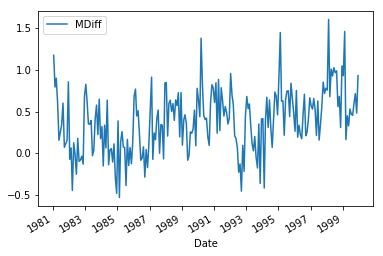

In [6]:
# For example...
df.query('Year>1980 & Year<2000').plot(x='Date', y='MDiff')
plt.show()

* Apply your moving average filter to the monthly data ```MDiff```. Try (for example) 6 months, 5 years, 10 years. Plot these on top of cuts of the original data to compare.

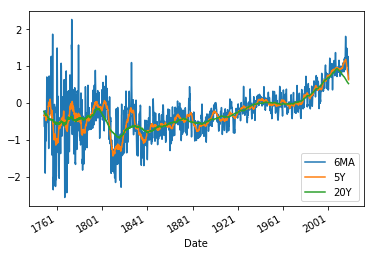

In [7]:
df['6MA'] = moving_average(df['MDiff'], 6)
df['5Y'] = moving_average(df['MDiff'], 60)
df['20Y'] = moving_average(df['MDiff'], 240)

df.plot(x='Date', y=['6MA', '5Y', '20Y'])
plt.show()

### 2.2 Electronic response of RC circuit

In general, the response of a linearly time invariant system is found to be the convolution of the its impulse response $h(t)$ and the input voltage. Consider a resistor and capacitor connected in series, driven by a time-varying voltage $u(t)$. The impulse response for such a circuit is:

$$h_c(t) = \frac{1}{RC} e^{-t/RC} u(t)$$

* Write a function to calculate the impulse response as a function of time, the resistance, and the capacitance, and input. Take care to normalise the integral.

* Now consider a noisy sinusoidal input voltage $u_N(t) = u(t) + \epsilon(t)$, where $\epsilon$ is a vector comprising samples draw from $N~(0,1)$. Plot the noisy signal and superimpose the clean signal.

* Calculate the circuit response for your signal and compare the result to the noisy signal and the clean, original signal

Play with the RC time constant and see the effect on the signal.


Note: this first order low pass filter is exactly equivalent to an exponential moving average. The "memory" of the output is effectively determined by the time constant.


Cutoff:  0.0005


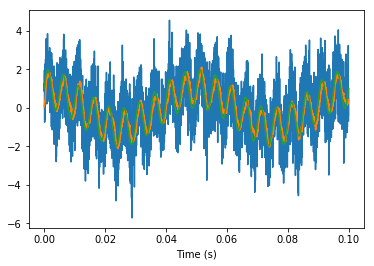

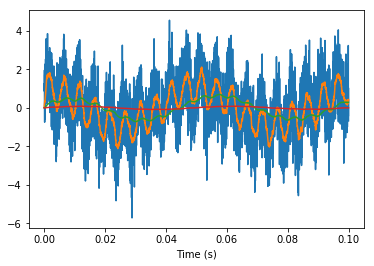

In [8]:
def rc_impulse(t, R, C):
    RC = R*C
    return 1/RC * np.exp(-t/RC)

def rc_response(t, u, R, C):
    return np.convolve(rc_impulse(t, R, C), u)[:len(t)]*dt

t = np.linspace(0, 0.1, 5000)
dt = t[1]-t[0]
R = 5e3
C = 100e-9
tc = R*C

fw = 200
u = np.sin(2*np.pi*fw*t) + np.cos(2*np.pi*0.1*fw*t)
un = u + np.random.randn(len(u))

print('Cutoff: ', tc)

plt.figure()
plt.plot(t, un)
plt.plot(t, rc_response(t, un, R, C))
plt.plot(t, u)
plt.xlabel('Time (s)')

# Try different cutoffs (remove noise, fast ripple, then whole thing)
plt.figure()
plt.plot(t, un)
plt.plot(t, rc_response(t, un, R, C))
plt.plot(t, rc_response(t, un, 20*R, C))
plt.plot(t, rc_response(t, un, 200*R, C))
plt.xlabel('Time (s)')
plt.show()



## 3. Monte Carlo methods
### 3.1. Particle propagation
The elementary processes of particle absorption and scattering are random in their nature. Propagation of particles through a slab of material with multiple scattering events may be impossible to calculate analytically, but can easily be simulated with Monte Carlo methods.

* Consider a beam of photons propagating through an absorbing medium with absorption coefficient $\alpha=0.2$ per unit length. What is the probability of a photon being absorbed in a unit length slab of material?

* Now take a piece of 1D material made up of 100 slices, each unit length. Starting at x=0, propagate a beam of 1000 photons through the material, slice-by-slice. At each interface, you should "measure" each photon to determine whether it has been transmitted or absorbed (hint: uniform distribution, $P(abs)$)

* Plot the number of photons which are transmitted at the end of each slice, and compare that to the Beer-Lambert-Bouger law

* Plot a histogram of the distance travelled before absorption for each photon (free paths).

$I(x) = I_{0}e^{-\alpha x }$ , where $\alpha$ is absorption coefficient

Generated absorption probability (mean) =  0.18105
Fraction of escaped particles =  0.0


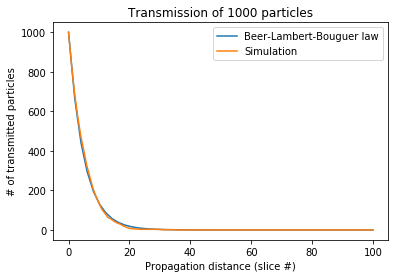

C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


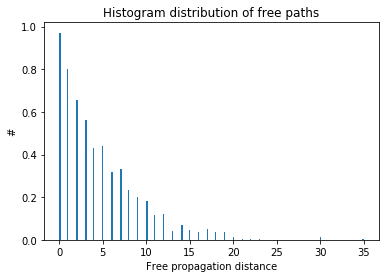

4.577


In [9]:
import numpy as np
import matplotlib.pyplot as plt

N_slices = 100 # Slices of material
N_particles = 1000 # Number of particles to simulate
alpha = 0.2 # absorption coefficient
P_abs = 1 - np.exp(-alpha) # Absorption probability in a slice

# Generate N_slices x N_particles matrix of uniformly distributed random numbers. 
# Transform it into a matrix of absorption events, where True = absorption, False = no absorption, 
# mean(ABs_events) = P_abs
Abs_events = np.random.uniform(0,1,(N_slices,N_particles)) < P_abs 
Abs_c = np.cumprod(Abs_events == False, axis=0)  # Propagate the absorbed state (False propagates)

free_path = np.sum(Abs_c, axis=0)  # Number of "True" (i.e. _not_ absorbed) until absorbed
N_transmitted = np.append([N_particles], np.sum(Abs_c, axis=1))
N_escaped_final = np.sum(free_path == N_slices)

print('Generated absorption probability (mean) = ', np.mean(Abs_events))
print('Fraction of escaped particles = ',N_escaped_final/N_particles)

x = np.linspace(0,N_slices);
plt.plot(x,N_particles*np.exp(-x*alpha), label = 'Beer-Lambert-Bouguer law') 
plt.plot(N_transmitted, label = 'Simulation')
plt.legend()
plt.xlabel('Propagation distance (slice #)')
plt.ylabel('# of transmitted particles')
plt.title('Transmission of %i particles' %N_particles)
plt.show()
#plt.hist(free_path[free_path!=np.inf],30,normed='True')
ax = plt.figure()
plt.hist(free_path,int(N_particles/5),normed='True')
plt.xlabel('Free propagation distance')
plt.ylabel('#')
plt.title('Histogram distribution of free paths')
plt.show()
print(np.mean(free_path))

### 3.2. Monte-Carlo integration: estimate $\pi$

In a so-called ’hit-and-miss’ approach, or ’simple sampling’, one can estimate the integral
of an arbitrary, well-behaved function over some interval by scattering many points over
some rectangular area A. The probability of a point landing below the curve is proportional
to the function’s integral.
A classic problem is to determine the value of π.

* Uniformly distribute N points over a unit area. Plot these on top of a unit circle (or quarter circle)
* Calculate the proportion that are within the bounds of your shape for some number of samples N (for large N, it would be unwise to plot)
* Repeat the exercise for increasing N. For each run, you should compute and store the error $\epsilon = \bar{\pi} - \pi$
* Plot log-log the convergence of your estimate to the actual value (to machine precision) of $\pi$, i.e. $\epsilon$ vs the number of points $N$. Compare this to the expected rate of convergence $(1/\sqrt N)$.

In [10]:
# Helper functions...
def mc_integrate_1d(f, dist_x, dist_y, n_iter):
    # Hit and miss version
    #
    # f: function to be evaluated
    # dist_x, dist_y: distributions from which to draw (x,y)
    # Does not handle -ve y
    x = dist_x(n_iter)
    y = dist_y(n_iter)
    h = f(x)
    return np.cumsum(y < f(x)) / np.arange(1,n_iter+1)

def mc_integrate_1d_2(f, dist_x, n_iter):
    # Sampling
    x = dist_x(n_iter)
    return np.cumsum(f(x))/np.arange(1,n_iter+1)

def plot_convergence(est, sol):
    x = np.arange(1,len(est)+1)
    plt.figure()
    plt.loglog(x, np.abs(est-sol)/sol, 'b', x, 1/np.sqrt(x), 'r')
    plt.legend(('Result', '1/sqrt(N)'))
    plt.xlabel('N iterations')
    plt.ylabel('Fractional error')


Pi estimate: 3.124


C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


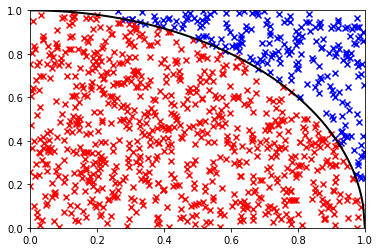

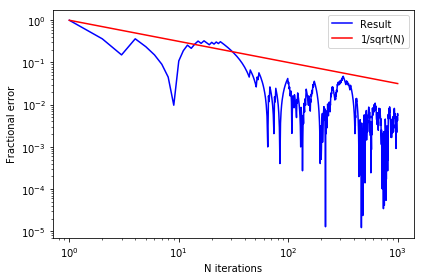

In [12]:
N_trials = int(1e3)
p = np.random.uniform(0,1,size=(N_trials, 2))
r = np.sqrt(np.sum(p**2, 1))

print('Pi estimate:', 4 * np.sum(r<=1) / N_trials)

sel = (r<=1, r>1)

def plot_pi(p, r, sel):
    x = np.linspace(0,1,200)
    fh, ax = plt.subplots()
    ax.hold(True)
    ax.scatter(p[sel[0],0], p[sel[0],1], c='r', marker='x')
    ax.scatter(p[sel[1],0], p[sel[1],1], c='b', marker='x')
    ax.plot(x, np.sqrt(1-x**2), 'k', linewidth=2)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

if N_trials <= 1e4:
    plot_pi(p,r,sel)

x = np.arange(1,N_trials+1)
c_est = 4*np.cumsum(sel[0])/x
c_err = np.abs(c_est-np.pi)/np.pi

# Std: sqrt(1/N(N-1) sum{(x_i-pi)^2})
plot_convergence(c_est, np.pi)
plt.tight_layout()
plt.show()